# 迁移学习
在 keras 预训练模型的基础上进行迁移学习。keras 中的模型：ResNet50、VGG16、Xception、Inception，等都在 ImageNet 上训练过，并取得了不错的准确率，在这些模型的网络基础上对猫狗数据集进行训练，以期快速提升准确率。

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import keras
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.optimizers import *
from keras.callbacks import *

print("keras version = %s" % keras.__version__)
print("numpy version = %s" % np.__version__)
print("tensorflow version = %s" % tf.__version__)

Using TensorFlow backend.


keras version = 2.1.5
numpy version = 1.14.2
tensorflow version = 1.6.0


# 一、使用预训练模型
* 构建函数，生成预训练模型

In [3]:
def build_pretrain_model(MODEL, img_size=(299, 299), 
                         prepro_func=None, optim=None, weights=None, freezeto=0, dropout=0.25):
    if MODEL == Xception and img_size[0] < 71:
        raise "Xception needs large size than 71"
    elif MODEL == VGG16 and img_size[0] < 48:
        raise "VGG16 needs larger size than 48"
    elif MODEL == VGG19 and img_size[0] < 48:
        raise "VGG19 needs larger size than 48"
    elif MODEL == ResNet50 and img_size[0] < 197:
        raise "ResNet50 needs larger size than 197"
    elif MODEL == InceptionV3 and img_size[0] < 139:
        raise "InceptionV3 needs larger size than 139"
    elif MODEL == InceptionResNetV2 and img_size[0] < 139:
        raise "InceptionResNetV2 needs larger size than 139"
        
    input_tensor = Input(shape=(img_size[1], img_size[0], 3))
    input_tensor = Lambda(prepro_func)(input_tensor)
    base_model = MODEL(input_tensor=input_tensor, weights='imagenet', include_top=False)
    
    for layers in base_model.layers:
        layers.trainable = False
    if freezeto > 0 and freezeto < len(base_model.layers):
        for layers in base_model.layers[freezeto:]:
            layers.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(dropout)(x)
    x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)
    
    mymodel = Model(inputs=base_model.input, outputs=x)
    optimizer = 'adadelta'
    if optim is not None:
        optimizer = optim
    mymodel.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    if weights is not None:
        mymodel.load_weights(weights)
    print('%s has %d layers.' % (MODEL.__name__, len(mymodel.layers)))
    return mymodel

In [4]:
img_gen = ImageDataGenerator(validation_split=0.2)
test_gen = ImageDataGenerator()
batch_size = 64

def build_generator(gen=img_gen, img_size=(299, 299), batch_size=32):
    train_generator = gen.flow_from_directory(directory='train3', 
                                              class_mode='binary', 
                                              target_size=img_size, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=42,
                                              subset='training')
    valid_generator = gen.flow_from_directory(directory='train3', 
                                              class_mode='binary', 
                                              target_size=img_size, 
                                              batch_size=batch_size, 
                                              shuffle=True,
                                              seed=42,
                                              subset='validation')
    test_generator = test_gen.flow_from_directory(directory='test2',
                                                  class_mode=None,
                                                  target_size=img_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  subset=None)
    return train_generator, valid_generator, test_generator

train_generator, valid_generator, test_generator = build_generator(batch_size=batch_size)

Found 19848 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [5]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))


In [6]:
def plot_hist(name='', hist=[]):
    t1 = np.arange(len(hist['acc']))
    t2 = np.arange(len(hist['loss']))
    fig, (ax0, ax1) = plt.subplots(2, 1)

    l1, l2 = ax0.plot(t1, hist['acc'], t1, hist['val_acc'])
    l3, l4 = ax1.plot(t2, hist['loss'], t2, hist['val_loss'])
    
    ax0.set_title('%s Learning history' % name)
    ax0.legend((l1, l2), ('acc', 'val_acc'), loc='best', shadow=True)
    ax1.legend((l3, l4), ('loss', 'val_loss'), loc='best', shadow=True)
    plt.show()

### 1、Xception  预训练模型

In [15]:
np.random.seed(42)
modelck_xce = ModelCheckpoint('xception_weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                              save_best_only=True, 
                              save_weights_only=True)
xception_model = build_pretrain_model(Xception, img_size=(299, 299),
                                      prepro_func=xception.preprocess_input)
hist_xce = xception_model.fit_generator(train_generator, epochs=5, 
                                        validation_data=valid_generator, 
                                        callbacks=[modelck_xce])

Xception has 136 layers.
Epoch 1/5
156/156 [==============================] - 156s 1s/step - loss: 0.1627 - acc: 0.9721 - val_loss: 0.1035 - val_acc: 0.9796
Epoch 2/5
156/156 [==============================] - 147s 942ms/step - loss: 0.0562 - acc: 0.9874 - val_loss: 0.0873 - val_acc: 0.9782
Epoch 3/5
156/156 [==============================] - 147s 940ms/step - loss: 0.0411 - acc: 0.9886 - val_loss: 0.0858 - val_acc: 0.9768
Epoch 4/5
156/156 [==============================] - 147s 940ms/step - loss: 0.0343 - acc: 0.9899 - val_loss: 0.0752 - val_acc: 0.9809
Epoch 5/5
156/156 [==============================] - 147s 945ms/step - loss: 0.0358 - acc: 0.9894 - val_loss: 0.0781 - val_acc: 0.9796


#### 观察模型训练过程：

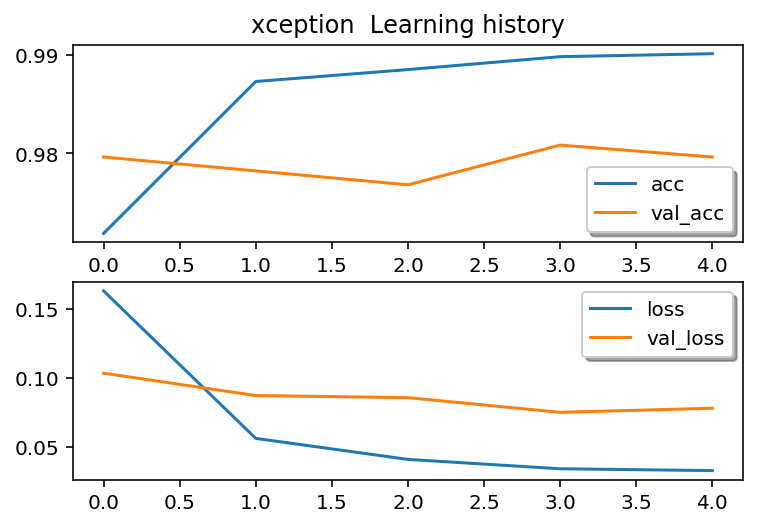

In [16]:
plot_hist('xception ', hist_xce.history)

#### 检查模型在测试集上的预测结果：

In [17]:
y_pred = xception_model.predict_generator(test_generator, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

98/98 [==============================] - 77s 786ms/step


In [18]:
xce_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    xce_pred.at[index-1, 'label'] = y_pred[i]
xce_pred.to_csv('xce_pred.csv', index=False)
xce_pred.head(10)

,id,label
0,1,0.975608
1,2,0.995000
2,3,0.995000
3,4,0.987690
4,5,0.005000
5,6,0.005000
6,7,0.005000
7,8,0.005000
8,9,0.005000
9,10,0.005000


### 2、VGG16预训练模型

In [20]:
train_generator, valid_generator, test_generator = build_generator(batch_size=batch_size, img_size=(224, 224))
modelck_vgg = ModelCheckpoint('VGG16_weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                              save_best_only=True, 
                              save_weights_only=True)
vgg_model = build_pretrain_model(VGG16, img_size=(224, 224),
                                 prepro_func=vgg16.preprocess_input)
hist_vgg = vgg_model.fit_generator(train_generator, epochs=5, 
                                   validation_data=valid_generator, 
                                   callbacks=[modelck_vgg])

Found 19848 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG16 has 23 layers.
Epoch 1/5
156/156 [==============================] - 145s 930ms/step - loss: 0.5427 - acc: 0.8815 - val_loss: 0.0946 - val_acc: 0.9710
Epoch 2/5
156/156 [==============================] - 135s 864ms/step - loss: 0.1315 - acc: 0.9627 - val_loss: 0.0620 - val_acc: 0.9809
Epoch 3/5
156/156 [==============================] - 135s 868ms/step - loss: 0.0925 - acc: 0.9714 - val_loss: 0.0502 - val_acc: 0.9839
Epoch 4/5
156/156 [==============================] - 135s 868ms/step - loss: 0.0769 - acc: 0.9766 - val_loss: 0.0454 - val_acc: 0.9853
Epoch 5/5
156/156 [==============================] - 135s 868ms/step - loss: 0.0630 - acc: 0.9807 - val_loss: 0.0436 - val_acc: 0.9857


#### 观察模型训练过程：

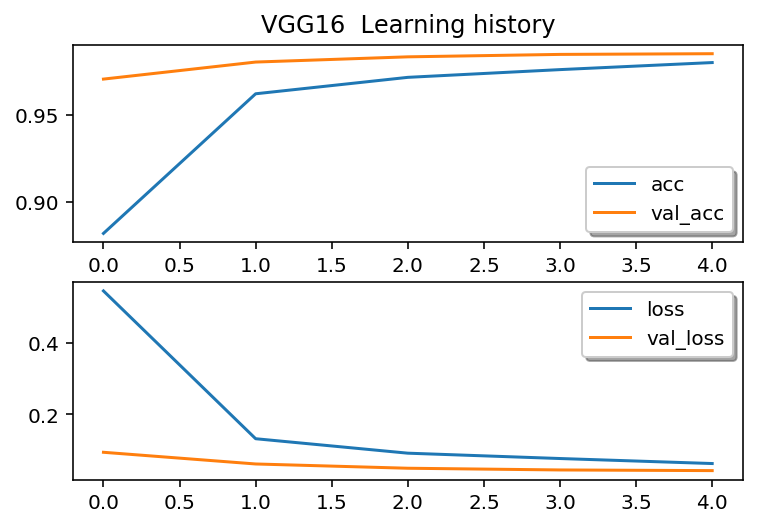

In [21]:
plot_hist('VGG16 ', hist_vgg.history)

#### 检查模型在测试集上的预测结果：

In [23]:
y_pred = vgg_model.predict_generator(test_generator, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

vgg_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    vgg_pred.at[index-1, 'label'] = y_pred[i]
vgg_pred.to_csv('vgg_pred.csv', index=False)
vgg_pred.head(10)

98/98 [==============================] - 73s 747ms/step


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


### 3、InceptionResNetV2预训练模型

In [24]:
train_generator, valid_generator, test_generator = build_generator(batch_size=batch_size, img_size=(299, 299))
modelck_irv2 = ModelCheckpoint('InReV2_weights.{epoch:02d}-{val_loss:.2f}.hdf5', 
                               save_best_only=True, 
                               save_weights_only=True)
irv2_model = build_pretrain_model(InceptionResNetV2, img_size=(299, 299),
                                  prepro_func=inception_resnet_v2.preprocess_input)
hist_irv2 = irv2_model.fit_generator(train_generator, epochs=5, 
                                     validation_data=valid_generator, 
                                     callbacks=[modelck_irv2])

Found 19848 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
219062272/219055592 [==============================] - 3s 0us/step
InceptionResNetV2 has 784 layers.
Epoch 1/5
156/156 [==============================] - 166s 1s/step - loss: 0.1964 - acc: 0.9530 - val_loss: 0.0735 - val_acc: 0.9863
Epoch 2/5
156/156 [==============================] - 156s 999ms/step - loss: 0.0838 - acc: 0.9792 - val_loss: 0.0696 - val_acc: 0.9833
Epoch 3/5
156/156 [==============================] - 156s 998ms/step - loss: 0.0624 - acc: 0.9819 - val_loss: 0.0810 - val_acc: 0.9782
Epoch 4/5
156/156 [==============================] - 155s 994ms/step - loss: 0.0565 - acc: 0.9811 - val_loss: 0.0762 - val_acc: 0.9792
Epoch 5/5
156/156 [==============================] - 156s 999ms/step - loss: 0.0507 - acc: 0.9836 - val_loss: 0.0651 - val_acc: 0.9845


#### 观察模型训练结果：

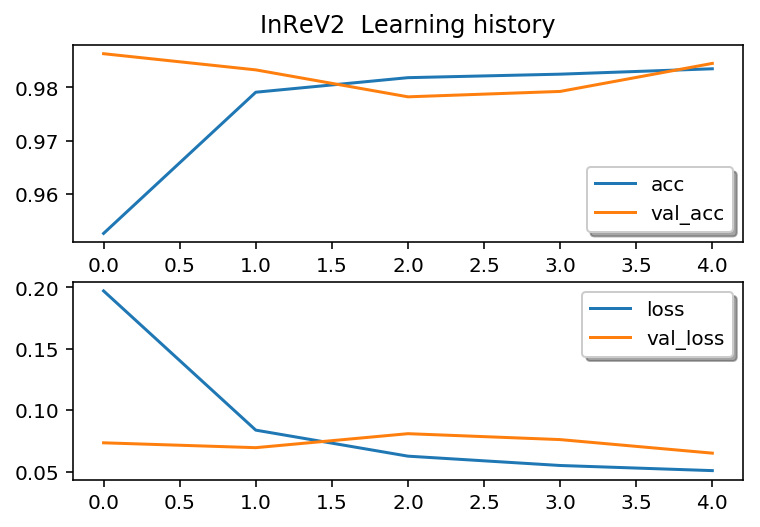

In [25]:
plot_hist('InReV2 ', hist_irv2.history)

#### 检查模型在测试集上的预测结果：

In [26]:
y_pred = irv2_model.predict_generator(test_generator, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

irv2_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    irv2_pred.at[index-1, 'label'] = y_pred[i]
irv2_pred.to_csv('irv2_pred.csv', index=False)
irv2_pred.head(10)

98/98 [==============================] - 83s 847ms/step


,id,label
0,1,0.983484
1,2,0.981847
2,3,0.982230
3,4,0.989512
4,5,0.005000
5,6,0.005000
6,7,0.005000
7,8,0.005000
8,9,0.005000
9,10,0.005000


# 二、微调模型

In [27]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________

In [9]:
train_generator, valid_generator, test_generator = build_generator(batch_size=batch_size, img_size=(224, 224))
finetune_model = build_pretrain_model(VGG16, 
                                      img_size=(224, 224), 
                                      prepro_func=vgg16.preprocess_input, 
                                      optim=None, 
                                      weights='VGG16_weights.05-0.04.hdf5', 
                                      freezeto=18,
                                      dropout=0.25)

early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelck_ft = ModelCheckpoint('finetune_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                             save_best_only=True,
                             save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)
tensor_board = TensorBoard(log_dir='./ft_logs1', 
                           histogram_freq=0, 
                           batch_size=batch_size, 
                           write_graph=False, 
                           write_grads=False, 
                           write_images=True)
hist_ft = finetune_model.fit_generator(train_generator, epochs=5, 
                                       validation_data=valid_generator, 
                                       callbacks=[early_stop, modelck_ft, reduce_lr, tensor_board])

Found 19848 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
VGG16 has 23 layers.
Epoch 1/5


KeyboardInterrupt: 

In [10]:
finetune_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________

In [ ]:
finetune_model.load_weights('')
for layer in ft_model.layers[freeze_layer:]:
    layer.trainable = True

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
finetune_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=1)
modelck_ft = ModelCheckpoint('finetune_weights_sgd.{epoch:02d}-{val_loss:.2f}.hdf5',
                           save_best_only=True,
                           save_weights_only=True)
tensor_board = TensorBoard(log_dir='./ft_logs2', 
                           histogram_freq=0, 
                           batch_size=batch_size, 
                           write_graph=False, 
                           write_grads=False, 
                           write_images=True)
hist_ft = finetune_model.fit_generator(train_generator, epochs=5, 
                                       validation_data=valid_generator, 
                                       callbacks=[early_stop, modelck_ft, tensor_board])

In [ ]:
plot_hist('Fine-tune ', hist_ft.history)

In [ ]:
y_pred = finetune_model.predict_generator(test_generator, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

ft_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    ft_pred.at[index-1, 'label'] = y_pred[i]
    
ft_pred.to_csv('finetune_pred.csv', index=False)
ft_pred.head(10)

# 三、模型融合

### 1、导出特征向量

In [10]:
def extract_features(MODEL, img_size=(299, 299), prepro_func=None, batch_size=64):
    
    input_tensor = Input(shape=(img_size[1], img_size[0], 3))
    x = Lambda(prepro_func)(input_tensor)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))
    
    gen = ImageDataGenerator()
    train_ext_gen = gen.flow_from_directory(directory='train3', 
                                            shuffle=False, 
                                            target_size=img_size, 
                                            batch_size=batch_size)
    test_ext_gen = gen.flow_from_directory(directory='test2', 
                                           shuffle=False,
                                           class_mode=None,
                                           target_size=img_size,
                                           batch_size=batch_size)
    
    train = model.predict_generator(train_ext_gen, verbose=1)
    test = model.predict_generator(test_ext_gen, verbose=1)
    
    with h5py.File("gap_%s.h5"%MODEL.func_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_ext_gen.classes)
    print('%s features extracted.' % MODEL.func_name)

In [ ]:
extract_features(ResNet50, img_size=(224, 224), prepro_func=resnet50.preprocess_input)

Found 24809 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [7]:
extract_features(Xception, prepro_func=xception.preprocess_input)

Found 24809 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


KeyboardInterrupt: 

In [ ]:
extract_features(InceptionV3, prepro_func=inception_v3.preprocess_input)

In [ ]:
extract_features(InceptionResNetV2, prepro_func=inception_resnet_v2.preprocess_input)

### 2、载入特征向量

In [ ]:
X_train = []
X_test = []

for filename in ["gap_ResNet50.h5", "gap_Xception.h5", "gap_InceptionV3.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

### 3、模型融合

(1) 利用已导出的特征进行融合

In [ ]:
input_tensor = Input(X_train.shape[1:])
x = Dropout(0.25)(input_tensor)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=128, epochs=8, validation_split=0.2)

In [ ]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

gap_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    gap_pred.at[index-1, 'label'] = y_pred[i]
    
gap_pred.to_csv('gap_pred.csv', index=False)
gap_pred.head(10)

(2) 直接构建融合模型

In [20]:
xce_model = Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False, pooling='avg')
inv3_model = InceptionV3(weights='imagenet', input_shape=(299, 299, 3), include_top=False, pooling='avg')
inrev2_model = InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top=False, pooling='avg')
rene50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg')

input_t1 = Input((299, 299, 3)) #xception, InceptionV3, InceptionResNetV2
a = Lambda(xception.preprocess_input)(input_t1)
a = xce_model(a)
b = Lambda(inception_v3.preprocess_input)(input_t1)
b = inv3_model(b)
c = Lambda(inception_resnet_v2.preprocess_input)(input_t1)
c = inrev2_model(c)

input_t2 = Input((224, 224, 3)) #ResNet50
d = Lambda(resnet50.preprocess_input)(input_t2)
d = rene50_model(d)

x = Concatenate()([a, b, c, d])
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

mixed_model = Model([input_t1, input_t2], x)
for layer in mixed_model.layers[:10]:
    layer.trainable = False

mixed_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
print('mixed_model has %d layers.' % (len(mixed_model.layers)))

mixed_model has 13 layers.


In [21]:
mixed_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 299, 299, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 299, 299, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
lambda_7 (

Fontconfig warning: ignoring UTF-8: not a valid region tag



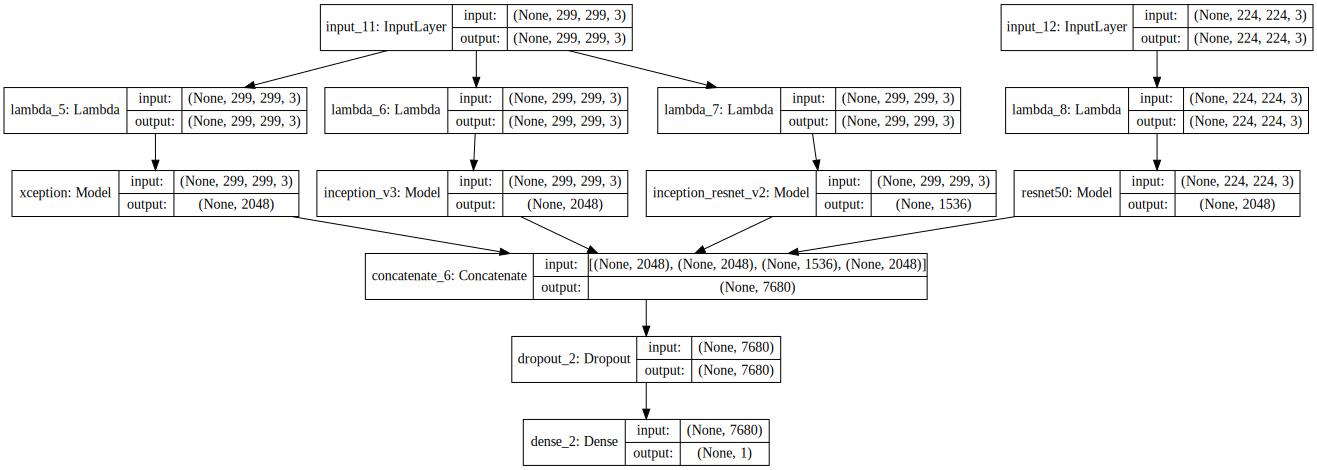

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import plot_model, model_to_dot

#plot_model(mixed_model, to_file='mixed_model.png')
SVG(model_to_dot(mixed_model, show_shapes=True).create(prog='dot', format='svg'))

In [29]:
batch_size = 50
train_generator, valid_generator, test_generator = build_generator(batch_size=batch_size, img_size=(299, 299))
def generate_generator_2inputs(gen=img_gen, directory='', 
                               size1=(299, 299), size2=(224, 224), 
                               subset=None, 
                               shuffle=True,
                               batch_size=32):
    genX1 = gen.flow_from_directory(directory=directory,
                                    target_size=size1,
                                    class_mode='binary',
                                    batch_size=batch_size,
                                    subset=subset,
                                    shuffle=shuffle,
                                    seed=42)
    
    genX2 = gen.flow_from_directory(directory=directory,
                                    target_size=size2,
                                    class_mode='binary',
                                    batch_size=batch_size,
                                    subset=subset,
                                    shuffle=shuffle,
                                    seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X2i[1]  #Yield both images and their mutual label
        
inputgenerator = generate_generator_2inputs(gen=img_gen, directory='train3',
                                            subset='training',
                                            batch_size=batch_size)       

validgenerator = generate_generator_2inputs(gen=img_gen, directory='train3',
                                            subset='validation',
                                            batch_size=batch_size)

testgenerator = generate_generator_2inputs(gen=test_gen, directory='test2',
                                           shuffle=False,
                                           batch_size=batch_size) 

Found 19848 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [30]:
train_steps = 19848//batch_size
valid_steps = 4961//batch_size

In [31]:
modelck_ft = ModelCheckpoint('mixed_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                            save_best_only=True,
                            save_weights_only=True)
mixed_hist = mixed_model.fit_generator(inputgenerator, epochs=3, 
                                       steps_per_epoch=train_steps,
                                       validation_data=validgenerator,
                                       validation_steps=valid_steps,
                                       callbacks=[modelck_ft])

Epoch 1/3
Found 19848 images belonging to 2 classes.
Found 19848 images belonging to 2 classes.
395/396 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9907Found 4961 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
396/396 [==============================] - 311s 784ms/step - loss: 0.0261 - acc: 0.9907 - val_loss: 0.0327 - val_acc: 0.9937
Epoch 2/3
396/396 [==============================] - 298s 754ms/step - loss: 0.0251 - acc: 0.9911 - val_loss: 0.0328 - val_acc: 0.9935
Epoch 3/3
396/396 [==============================] - 298s 753ms/step - loss: 0.0229 - acc: 0.9918 - val_loss: 0.0390 - val_acc: 0.9923


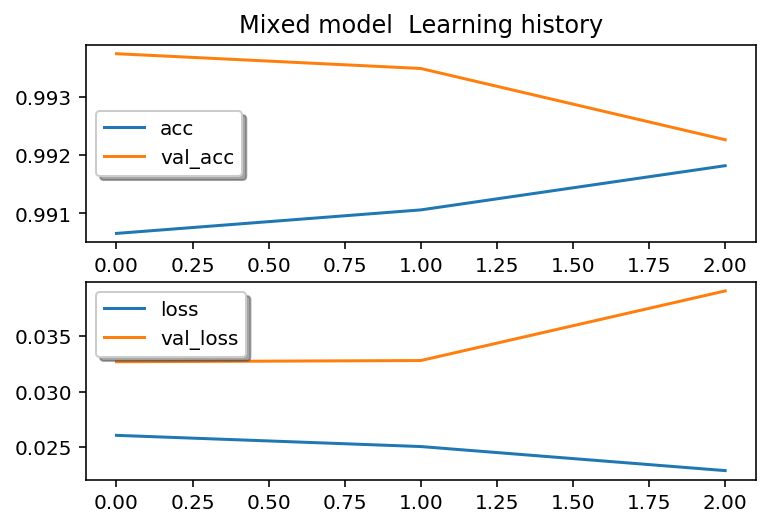

In [32]:
plot_hist('Mixed model ', mixed_hist.history)

In [33]:
y_pred = mixed_model.predict_generator(testgenerator, verbose=1, steps=12500//batch_size)
y_pred = y_pred.clip(min=0.005, max=0.995)

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.
250/250 [==============================] - 157s 627ms/step


In [35]:
mixed_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    mixed_pred.at[index-1, 'label'] = y_pred[i]

mixed_pred.to_csv('mixed_pred.csv', index=False)
mixed_pred.head(10)

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


In [47]:
xce_model = Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False, pooling='avg')
vgg_model = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg')
inrev2_model = InceptionResNetV2(weights='imagenet', input_shape=(299, 299, 3), include_top=False, pooling='avg')
rene50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3), include_top=False, pooling='avg')

input_t1 = Input((299, 299, 3)) #xception, InceptionV3, InceptionResNetV2
a = Lambda(xception.preprocess_input)(input_t1)
a = xce_model(a)
c = Lambda(inception_resnet_v2.preprocess_input)(input_t1)
c = inrev2_model(c)

input_t2 = Input((224, 224, 3)) #ResNet50
b = Lambda(vgg16.preprocess_input)(input_t2)
b = vgg_model(b)
d = Lambda(resnet50.preprocess_input)(input_t2)
d = rene50_model(d)

x = Concatenate()([a, c, b, d])
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x)

mixed2_model = Model([input_t1, input_t2], x)
for layer in mixed2_model.layers[:10]:
    layer.trainable = False

mixed2_model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
print('mixed_model has %d layers.' % (len(mixed2_model.layers)))

mixed_model has 13 layers.


Fontconfig warning: ignoring UTF-8: not a valid region tag



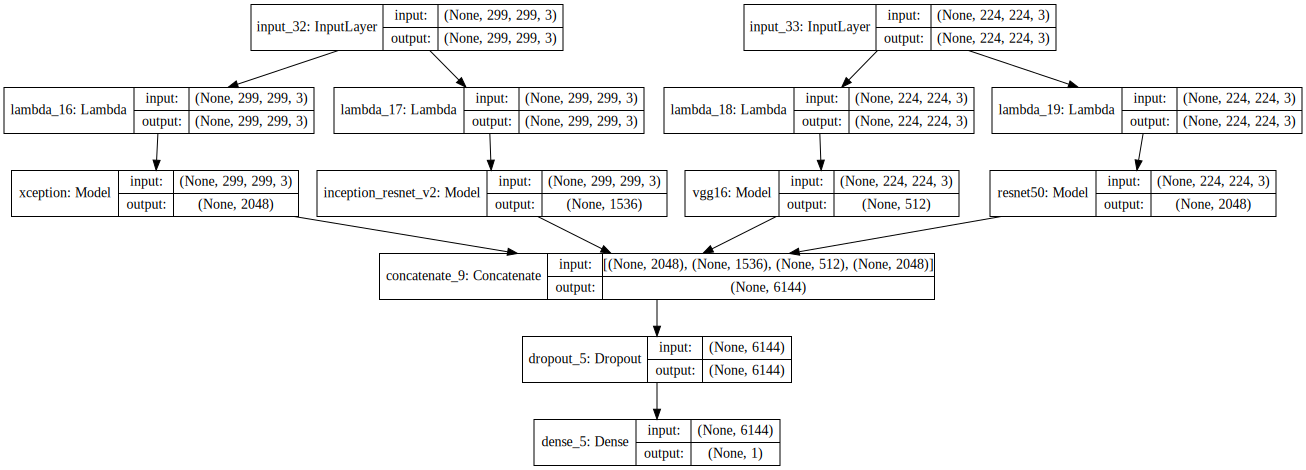

In [48]:
SVG(model_to_dot(mixed2_model, show_shapes=True).create(prog='dot', format='svg'))

In [49]:
batch_size = 50
train_generator, valid_generator, test_generator = build_generator(batch_size=batch_size, img_size=(299, 299))
        
inputgenerator = generate_generator_2inputs(gen=img_gen, directory='train3',
                                            subset='training',
                                            batch_size=batch_size)       

validgenerator = generate_generator_2inputs(gen=img_gen, directory='train3',
                                            subset='validation',
                                            batch_size=batch_size)

testgenerator = generate_generator_2inputs(gen=test_gen, directory='test2',
                                           shuffle=False,
                                           batch_size=batch_size) 

Found 19848 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [50]:
modelck_ft = ModelCheckpoint('mixed2_weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                            save_best_only=True,
                            save_weights_only=True)
mixed2_hist = mixed2_model.fit_generator(inputgenerator, epochs=3, 
                                       steps_per_epoch=train_steps,
                                       validation_data=validgenerator,
                                       validation_steps=valid_steps,
                                       callbacks=[modelck_ft])

Epoch 1/3
Found 19848 images belonging to 2 classes.
Found 19848 images belonging to 2 classes.
395/396 [============================>.] - ETA: 0s - loss: 0.0863 - acc: 0.9670Found 4961 images belonging to 2 classes.
Found 4961 images belonging to 2 classes.
396/396 [==============================] - 415s 1s/step - loss: 0.0865 - acc: 0.9670 - val_loss: 0.0371 - val_acc: 0.9893
Epoch 2/3
396/396 [==============================] - 307s 776ms/step - loss: 0.0374 - acc: 0.9875 - val_loss: 0.0258 - val_acc: 0.9935
Epoch 3/3
396/396 [==============================] - 306s 774ms/step - loss: 0.0291 - acc: 0.9895 - val_loss: 0.0340 - val_acc: 0.9925


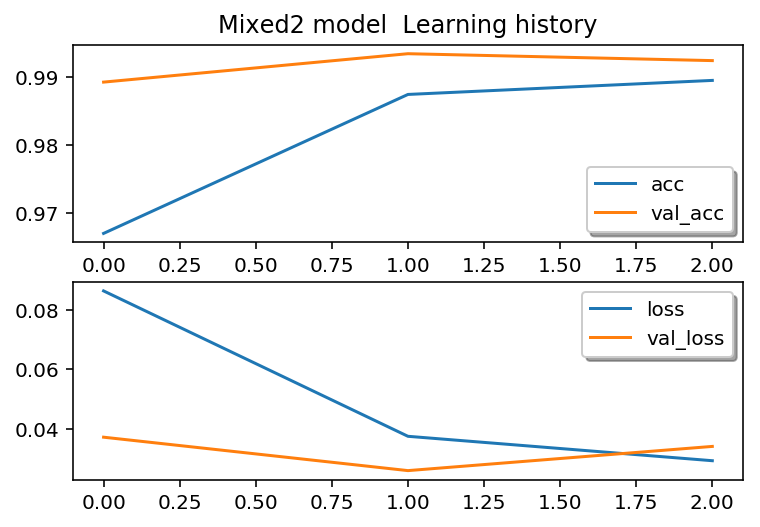

In [51]:
plot_hist('Mixed2 model ', mixed2_hist.history)

In [52]:
y_pred = mixed_model.predict_generator(testgenerator, verbose=1, steps=12500//batch_size)
y_pred = y_pred.clip(min=0.005, max=0.995)

Found 12500 images belonging to 1 classes.
Found 12500 images belonging to 1 classes.
250/250 [==============================] - 161s 642ms/step


In [53]:
mixed2_pred = pd.read_csv("sample_submission.csv")
for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    mixed2_pred.at[index-1, 'label'] = y_pred[i]

mixed2_pred.to_csv('mixed2_pred.csv', index=False)
mixed2_pred.head(10)

,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005


# 四、结论